# Intro

Here, we'll try to do a comprehensive guide through some topics over getting data from Twitter's API, parsing the texts with some NLP packages and finally trying to do some graph analysis.

Sometimes, the approach may seen simplistic, but this is the very basic in order to start to analyze text-based data.

What we'll use:

- Tweepy
- nltk
- SpaCy
- Networkx
- igraph
- Pandas (of course!)
- Some other helper libraries

Without further comments... Let's do it!

In [1]:
# Let's ensure that we install some packages on our Kaggle VM
!pip install tweepy nltk spacy python-louvain python-igraph

In [2]:
# Installs spacy portuguese model
!python -m spacy download pt_core_news_sm

     |████████████████████████████████| 21.2 MB 767 kB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-py3-none-any.whl size=21186283 sha256=70318e1a4ff11fbeff109bcbbb55565a17c754d65dbef0ea9624de1be060663a
  Stored in directory: /tmp/pip-ephem-wheel-cache-holszqp2/wheels/c3/f9/0c/5c014a36941a00f5df5fc0756cb961d7c457a978e697a6ce3b
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import community as community_louvain
from igraph import *

from IPython.display import Image
import matplotlib.pyplot as plt

import os, tweepy, sys, unicodedata, re, csv, spacy, ast
from time import sleep, time, strptime, strftime
from datetime import date, datetime, timedelta
from unidecode import unidecode

from nltk.corpus import stopwords

In [4]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import pt_core_news_sm

In [6]:
# Loads SpaCy's model
nlp = pt_core_news_sm.load(disable=['tagger', 'ner', 'textcat'])
#nlp = English().from_disk("/model", disable=["ner"])

# 1. First things first

We're going to use a twitter library called Tweepy to get data from twitter first. Then, we'll process this data and finally generate some graphs analysis based on the words of each tweet.

So, it's handy to know that Twitter may operate with two main kinds of API: a REST API and a Streaming API. If you're retroactively trying to get data from the past few months, you're going to use the former. But if you think that you might find yourself dealing with Rate Limits (and you know what you're going to search) -- or you just don't care -- you're going for the latter.

There are several little rules that we have to deal with when calling their API. We could build our own solution from scratch, but, actually, we'll be using a little helper here: **Tweepy**.

References: https://www.kaggle.com/caractacus/thematic-text-analysis-using-spacy-networkx

## **1.1. Tweepy**

We'll take care of our authentication process. Supposing that you already have generated your credentials/secrets at https://developer.twitter.com/, we're going to set our credentials like this:

In [7]:
# Getting secrets from Kaggle
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

CONSUMER_KEY = user_secrets.get_secret("CONSUMER_KEY")
CONSUMER_SECRET = user_secrets.get_secret("CONSUMER_SECRET")
ACCESS_TOKEN = user_secrets.get_secret("ACCESS_TOKEN")
ACCESS_TOKEN_SECRET = user_secrets.get_secret("ACESS_TOKEN_SECRET")

In [8]:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

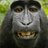

In [9]:
# And we may call the REST API only to check if our credentials are ok!
api = tweepy.API(auth)
Image(api.me()._json['profile_image_url_https'])

All right! My photo is a happy monkey!


Now, we have to work with the Streaming API. The rule here is:

* We have to inherit a class from tweepy.StreamListener
* Then, we have to override a few methods in order to define how to deal with the data and errors (and RATE LIMITS)
* Finally, we'll instantiate our streaming API object and...
* We'll call its filter method

### 1.1.1. StreamListener

There are some peculiarities when we're dealing with tweets, retweets and extended tweets (the ones > 140 characters). So we'll *try* to figure it out.

In [10]:
class CustomStreamListener(tweepy.StreamListener):
    def __init__(self, time_limit=25):
        # For now, we won't want this class to be running forever
        
        self.start_time = time()
        
        self.limit = time_limit
        
        super(CustomStreamListener, self).__init__()

    def on_status(self, status): # First, we'll deal with the incoming statuses
        
        # A little note to limit the streaming time!
        if (time() - self.start_time) >= self.limit:
            return False

        # We'll check if retweet
        is_retweet =  hasattr(status, 'retweeted_status')

        # Then, we'll check if extended tweet
        if hasattr(status, 'extended_tweet'):
            
            text = status.extended_tweet['full_text']
            
        else:  # if neither of them
            
            text = status.text
           

        # BUT let's check if quote tweet
        is_quote_tweet = hasattr(status, 'quoted_status')
        quoted_text = ''

        if is_quote_tweet:
            # And if it is, let's check if quote tweet has been truncated
            
            if hasattr(status.quoted_status, 'extended_tweet'):
                
                quoted_text = status.quoted_status.extended_tweet['full_text']
                
            else:
                
                quoted_text = status.quoted_status.text
                
        # Then, let's define what we're going to get
        id_str = status.id_str
        created_at = status.created_at
        user_screen_name = status.user.screen_name
        user_location = status.user.location
        followers_count = status.user.followers_count
        retweet_count = status.retweet_count
        status_source = status.source
        mentions = status.entities['user_mentions']
        
        print(str(id_str), 
              str(created_at), 
              str(user_screen_name), 
              str(user_location), 
              str(followers_count), 
              str(retweet_count), 
              str(status_source), 
              str(text),
             '\n -> User mentions: {}'.format(str(mentions)))

After this, we'll define the subjects we want to filter from the stream, instantiate the streaming_api object and finally start to filter things out. Trying not to have an anxiety attack about the world, I'll stick to pop singers.

In [11]:
SUBJECTS = ['Lady Gaga', 'Katy Perry', 'Dua Lipa', 'Beyonce', 
            'Taylor Swift', 'Ariana Grande', 'Miley Cyrus', 'Selena Gomez']

In [12]:
# Then, we create the streaming_api object
streaming_api = tweepy.streaming.Stream(auth, CustomStreamListener(), 
                                        timeout=25, tweet_mode='extended')

# Here, we also define the portuguese language (hence the pt comes from)
streaming_api.filter(track=SUBJECTS, languages=['pt'], is_async=False) 

1275912359563984897 2020-06-24 22:03:06 lmjscrew Ele/Dele 2795 0 Twitter for Android RT @PortalSelenaBR: “Quando eu ouvi pela primeira vez amei o fato de que era uma história sobre todas as coisas as quais costumamos nos ape… 
 -> User mentions: [{'screen_name': 'PortalSelenaBR', 'name': 'Portal Selena Brasil', 'id': 475820441, 'id_str': '475820441', 'indices': [3, 18]}]
1275912366144851969 2020-06-24 22:03:08 trokino São Paulo, Brasil 103 0 Twitter Web App Pq ninguém me apresentou All Night da @Beyonce antes???
Eu to completamente FASCINADA nesse clipe, na letra e na música em si pqp, amei! 
 -> User mentions: [{'screen_name': 'Beyonce', 'name': 'BEYONCÉ', 'id': 31239408, 'id_str': '31239408', 'indices': [38, 46]}]
1275912380933910528 2020-06-24 22:03:11 lexaok9 Porto Velho, Brasil 1076 0 Twitter for Android RT @RDTLadyGaga: Promovendo o "Chromatica", Adobe e Lady Gaga lançam concurso para designers com prêmio de $10,000
https://t.co/IEhGLAmgcI… 
 -> User mentions: [{'screen_name': 'R

All right, it looks like our class and our print statement are functioning correctly! But we missed a lot of things here, like error handling and, more important than anything: rate limiting. We don't want to be blocked by Twitter, right?

So, let's improve our CustomStreamListener class:

In [13]:
class CustomStreamListener(tweepy.StreamListener):
    def __init__(self, time_limit=25):
        
        # For now, we won't want this class to be running forever
        self.start_time = time()
        
        self.limit = time_limit
        
        super(CustomStreamListener, self).__init__()

    def on_status(self, status): # First, we'll deal with the incoming statuses
        
        # A little note to limit the streaming time!
        if (time() - self.start_time) >= self.limit:
            return False # Return False kills the stream

        # We'll check if retweet
        is_retweet =  hasattr(status, 'retweeted_status')

        # Then, we'll check if extended tweet
        if hasattr(status, 'extended_tweet'):
            
            text = status.extended_tweet['full_text']
            
        else:  # if neither of them
            
            text = status.text
           

        # BUT let's check if quote tweet
        is_quote_tweet = hasattr(status, 'quoted_status')
        quoted_text = ''

        if is_quote_tweet:
            
            # And if it is, let's check if quote tweet has been truncated            
            if hasattr(status.quoted_status, 'extended_tweet'):
                
                quoted_text = status.quoted_status.extended_tweet['full_text']
                
            else:
                
                quoted_text = status.quoted_status.text
                
        # Then, let's define what we're going to get
        id_str = status.id_str
        created_at = status.created_at
        user_screen_name = status.user.screen_name
        user_location = status.user.location
        followers_count = status.user.followers_count
        retweet_count = status.retweet_count
        status_source = status.source
        mentions = status.entities['user_mentions']

        # It's useful to clean some undesired characters 
        # From https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python/49146722#49146722
        emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

        text = emoji_pattern.sub(r'', text)
        quoted_text = emoji_pattern.sub(r'', quoted_text)
      
        try: # save to csv 
            
            # We can convert, optionally, the created_at timezone to 
            # our own (this is mine, at Brazil)
            conv_created_at = created_at - timedelta(hours=3)

            # this block saves effectively to csv, appending to the 
            # file with the respective date
            with open('{}.csv'
                      .format(conv_created_at
                              .date()
                              .strftime('%Y%m%d')),
                      mode='a', 
                      newline='', 
                      encoding='utf-8') as csvfile:

                csvwriter = csv.writer(csvfile, delimiter=',')

                csvwriter.writerow([id_str, 
                                    created_at, 
                                    conv_created_at, 
                                    text,
                                    quoted_text, 
                                    is_retweet, 
                                    user_screen_name, 
                                    user_location, 
                                    followers_count,
                                    retweet_count,
                                    status_source,
                                    mentions])
            
        except Exception as e:
                print("Error saving to csv: ", e)
                return
            
    #####                #####
    ##### ERROR HANDLING #####
    #####                #####
    
    def on_error(self, status_code):  # Here, we'll deal with general errors. 
        # We'll append the error to a log.txt file
        
        with open('log.txt', 'a') as f:
            
            f.write('Encountered error with status code: ' + 
                    str(status_code) + ',' + str(datetime.now()) + '\n')
        
        return True # Returning True doesn't kill the stream
    
    
    def on_limit(self, status_code): # Here, we'll deal with the most 
                                            # feared error: Rate Limits
        
        with open('log.txt', 'a') as f:
            
            f.write('Rate Limit Exceeded... ' + str(status_code) + ',' + str(datetime.now()) + '\n')
        
        return True  # Fun stuff: when you return True here, Tweepy takes care by
                        # exponentially increasing the time between each call
                        # when you Rate Limit, as per Twitter docs here: 
                        # https://developer.twitter.com/en/docs/basics/rate-limiting

            
    def on_disconnect(self, notice): 
        # Sometimes, twitter may disconnect 
        # you, for some reason.        
        # You may read more about it here 
        # https://developer.twitter.com/en/docs/tutorials/consuming-streaming-data#disconnections
        
        with open('log.txt', 'a') as f:  
            
            f.write('Disconnected: ' + str(notice) + ',' + str(datetime.now()) + '\n')
        
        sleep(2)
        
        return False # Obviously, the stream is killed

    
    def on_timeout(self): # And other times, you may only find a timeout.
        
        with open('log.txt', 'a') as f:
            
            f.write('Timeout... ' + ',' + str(datetime.now()) 
                    + '\n') # We log the incident...
        
        sleep(60) # We wait...
        
        return True # We try again (don't kill the stream)

In [14]:
# Ensure we're on this folder
os.chdir('/kaggle/working')

In [15]:
# Then, we create the streaming_api object
streaming_api = tweepy.streaming.Stream(auth, CustomStreamListener(), 
                                        timeout=25, tweet_mode='extended')

# Here, we also define the portuguese language (hence the pt comes from)
streaming_api.filter(track=SUBJECTS, languages=['pt'], is_async=False) 

# **2. NLP**

Let's structure our data as dataframe.

In [16]:
cols = ['id_str',
        'created_at',
        'conv_created_at',
        'text',
        'quoted_text',
        'is_retweet',
        'user_screen_name',
        'user_location',
        'followers_count',
        'retweet_count',
        'status_source',
        'mentions']

# To automatically read our data from the current day, we'd use this. 
# But we're going to use a previously saved file today.
# df = pd.read_csv((datetime.today() - timedelta(hours=3)).strftime('%Y%m%d') + '.csv',
#           names = cols, encoding='utf-8')
# df.head()

In [17]:
# This is the previously saved file
df = pd.read_csv('/kaggle/input/sample_data.csv', 
                 names=['id_str', 'created_at','conv_created_at', 'text',
                        'quoted_text', 'is_retweet', 'user_screen_name', 
                        'user_location', 'followers_count', 'retweet_count', 
                        'status_source', 'mentions'])

In [18]:
# Taking a sample
df = df.iloc[:500,:]

In [19]:
print('Dataframe shape: ' + str(df.shape))

Dataframe shape: (500, 12)


In [20]:
df.head()

,id_str,created_at,conv_created_at,text,quoted_text,is_retweet,user_screen_name,user_location,followers_count,retweet_count,status_source,mentions
0,1275235258263371782,2020-06-23 01:12:32,2020-06-22 22:12:32,"Que ódio, a Ariana Grande não tem uma música r...",NaN,False,and_juju_ofc,"Rio de Janeiro, Brasil",1279,0,Twitter for iPhone,[]
1,1275235260356276226,2020-06-23 01:12:33,2020-06-22 22:12:33,RT @acessokatyperry: “Tenho gravado performanc...,NaN,True,perryinhawaii,NaN,557,0,Twitter for Android,"[{'screen_name': 'acessokatyperry', 'name': 'A..."
2,1275235268061270016,2020-06-23 01:12:35,2020-06-22 22:12:35,RT @AcervoCharts: Diretor executivo de Katy Pe...,NaN,True,lexaok9,"Porto Velho, Brasil",1077,0,Twitter for Android,"[{'screen_name': 'AcervoCharts', 'name': 'ACha..."
3,1275235275225075713,2020-06-23 01:12:36,2020-06-22 22:12:36,RT @MileyRevoIution: Miley Cyrus de Marilyn Mo...,NaN,True,nsnjbmc,"7i41pm, september 11, 2014.",15111,0,Twitter for Android,"[{'screen_name': 'MileyRevoIution', 'name': 'M..."
4,1275235276726644737,2020-06-23 01:12:37,2020-06-22 22:12:37,RT @Roarazes: música ruim? desculpa não sei o ...,"música ruim? desculpa não sei o quê é, é que e...",True,drunkskaty,Paraná,2599,0,Twitter for iPhone,"[{'screen_name': 'Roarazes', 'name': 'Samuel',..."


Now, we'll want to process the text using a NLP pipeline. We'll tokenize the text and remove stopwords -- words that are too frequent in a language.

In [21]:
# This is an example of Portuguese stopwords
sr = stopwords.words('portuguese')
print(sr)
print(len(sr))

['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estiv

In [22]:
# Remove RT, links, special characters, 
# hashtags, mentions (these are on entities object)

# Makes everything lowercase
df['text'] = df['text'].str.lower()
df['quoted_text'] = df['quoted_text'].str.lower()

# Removes the word RT
df['replaced_text'] = df['text'].str.replace(r'\s*rt\s', '',
                                             case=True, 
                                             regex=True)

# Replacing @s and #s terms - Or you can use this regex 
# as a way to find and store these values
# Or you can use the Twitter's Entities object: 
# https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object
df['replaced_text'] = df['replaced_text'].str.replace(r'\s([@#][\w_-]+)', '',
                                                      case=False,
                                                      regex=True)

# Replaces URLs in any position (start, middle or end)- Or you can use this regex as a way to find and store these values
df['replaced_text'] = df['replaced_text'].str.replace(r'http\S+\s|\swww.\S+\s|http\S+|www.\S+|\shttp\S+|\swww.\S+', '', 
                                                      case=False)

# Removes special characters from words. Ex. amanhã -> amanha
df['replaced_text'] = df['replaced_text'].apply(lambda text: unidecode(text))
#df['replaced_quoted_text'] = df['replaced_quoted_text'].apply(lambda text: unidecode(text))


# Removes any remaining special characters
df['replaced_text'] = df['replaced_text'].str.replace(r'[^0-9a-zA-Z ]+', '', 
                                                      case=False, 
                                                      regex=True)

# Same as before for the the quoted text
#df['replaced_quoted_text'] = df['replaced_quoted_text'].str.replace(r'(^|[ ])rt', '', case=False)
#df['replaced_quoted_text'] = df['quoted_text'].str.replace(r'\s([@#][\w_-]+)', '', case=False)
#df['replaced_quoted_text'] = df['replaced_quoted_text'].str.replace(r'http\S+\s|\swww.\S+\s|http\S+|www.\S+|\shttp\S+|\swww.\S+', '', case=False)
#df['replaced_quoted_text'] = df['replaced_quoted_text'].str.replace(r'[^0-9a-zA-Z ]+', '', case=False)

This is the structure, now...

In [23]:
df[['text', 'replaced_text']].head()

,text,replaced_text
0,"que ódio, a ariana grande não tem uma música r...",que odio a ariana grande nao tem uma musica ru...
1,rt @acessokatyperry: “tenho gravado performanc...,acessokatyperry tenho gravado performances em ...
2,rt @acervocharts: diretor executivo de katy pe...,acervocharts diretor executivo de katy perry s...
3,rt @mileyrevoiution: miley cyrus de marilyn mo...,mileyrevoiution miley cyrus de marilyn monroe ...
4,rt @roarazes: música ruim? desculpa não sei o ...,roarazes musica ruim desculpa nao sei o que e ...


Now, we'll use Spacy over our replaced text.

In [24]:
# See https://www.kaggle.com/caractacus/thematic-text-analysis-using-spacy-networkx
tokens = []
parsed_doc = [] 
col_to_parse = 'replaced_text'

for doc in nlp.pipe(df[col_to_parse].astype('unicode').values, batch_size=50,
                        n_threads=3):
    if doc.is_parsed:
        parsed_doc.append(doc)
        tokens.append([n.text for n in doc if n.text not in sr])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, 
        # so add some blanks in case the parse fails
        parsed_doc.append(None)
        tokens.append(None)


df['parsed_doc'] = parsed_doc
df['tokenized'] = tokens

# Ensure that we won't have any whitespace on tokens
df['tokenized'] = df['tokenized'].apply(lambda text: [word for word in text if word != ' '])

In [25]:
df.head()

,id_str,created_at,conv_created_at,text,quoted_text,is_retweet,user_screen_name,user_location,followers_count,retweet_count,status_source,mentions,replaced_text,parsed_doc,tokenized
0,1275235258263371782,2020-06-23 01:12:32,2020-06-22 22:12:32,"que ódio, a ariana grande não tem uma música r...",NaN,False,and_juju_ofc,"Rio de Janeiro, Brasil",1279,0,Twitter for iPhone,[],que odio a ariana grande nao tem uma musica ru...,"(que, odio, a, ariana, grande, nao, tem, uma, ...","[odio, ariana, grande, nao, musica, ruim, mulh..."
1,1275235260356276226,2020-06-23 01:12:33,2020-06-22 22:12:33,rt @acessokatyperry: “tenho gravado performanc...,NaN,True,perryinhawaii,NaN,557,0,Twitter for Android,"[{'screen_name': 'acessokatyperry', 'name': 'A...",acessokatyperry tenho gravado performances em ...,"(acessokatyperry, tenho, gravado, performances...","[acessokatyperry, gravado, performances, estud..."
2,1275235268061270016,2020-06-23 01:12:35,2020-06-22 22:12:35,rt @acervocharts: diretor executivo de katy pe...,NaN,True,lexaok9,"Porto Velho, Brasil",1077,0,Twitter for Android,"[{'screen_name': 'AcervoCharts', 'name': 'ACha...",acervocharts diretor executivo de katy perry s...,"(acervocharts, diretor, executivo, de, katy, p...","[acervocharts, diretor, executivo, katy, perry..."
3,1275235275225075713,2020-06-23 01:12:36,2020-06-22 22:12:36,rt @mileyrevoiution: miley cyrus de marilyn mo...,NaN,True,nsnjbmc,"7i41pm, september 11, 2014.",15111,0,Twitter for Android,"[{'screen_name': 'MileyRevoIution', 'name': 'M...",mileyrevoiution miley cyrus de marilyn monroe ...,"(mileyrevoiution, miley, cyrus, de, marilyn, m...","[mileyrevoiution, miley, cyrus, marilyn, monro..."
4,1275235276726644737,2020-06-23 01:12:37,2020-06-22 22:12:37,rt @roarazes: música ruim? desculpa não sei o ...,"música ruim? desculpa não sei o quê é, é que e...",True,drunkskaty,Paraná,2599,0,Twitter for iPhone,"[{'screen_name': 'Roarazes', 'name': 'Samuel',...",roarazes musica ruim desculpa nao sei o que e ...,"(roarazes, musica, ruim, desculpa, nao, sei, o...","[roarazes, musica, ruim, desculpa, nao, sei, f..."


 # **2. Graph Analysis on text using NetworkX**

Now, we'll see a little bit about graphs. First, we'll see how the texts are usually structured. In other words, we'll see how words relate to each other.

In [26]:
# We could can all the words that are related with the
# code snippet below.
df['edges'] = df['tokenized'].apply(lambda col: tuple(((x,y) for x in col for y in col if x != y)))

df['edges'].head()

0    ((odio, ariana), (odio, grande), (odio, nao), ...
1    ((acessokatyperry, gravado), (acessokatyperry,...
2    ((acervocharts, diretor), (acervocharts, execu...
3    ((mileyrevoiution, miley), (mileyrevoiution, c...
4    ((roarazes, musica), (roarazes, ruim), (roaraz...
Name: edges, dtype: object

In [27]:
# Adapted from https://www.kaggle.com/caractacus/thematic-text-analysis-using-spacy-networkx
G = nx.Graph() # undirected
n = 0

for row in df.iterrows():
    
    for tup in row[1]['edges']:
        
        G.add_edge(tup[0], tup[1])
        
        n += 1        

In [28]:
print(G.number_of_nodes(), "nodes, and", G.number_of_edges(), "edges created.")

1695 nodes, and 19694 edges created.


Here, the purpose is to find communities based on text structure!

In [29]:
# https://stackoverflow.com/questions/40941264/how-to-draw-a-small-graph-with-community-structure-in-networkx
partition = community_louvain.best_partition(G)

In [30]:
# Assigning a position to the nodes
pos=nx.spring_layout(G)

In [31]:
# To check edges:
# G.edges()

In [32]:
# Check partition values
partition.values()

dict_values([0, 0, 0, 1, 2, 3, 3, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 6, 2, 4, 4, 2, 5, 7, 4, 4, 5, 7, 7, 7, 7, 3, 7, 8, 8, 8, 8, 8, 8, 4, 8, 8, 6, 9, 8, 8, 4, 3, 6, 7, 5, 5, 5, 5, 5, 5, 10, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 5, 7, 0, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 8, 8, 8, 5, 2, 5, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 7, 9, 7, 7, 9, 7, 3, 3, 3, 3, 12, 7, 12, 10, 12, 13, 1, 1, 4, 4, 4, 13, 4, 4, 12, 8, 4, 4, 5, 12, 12, 12, 12, 12, 12, 12, 12, 12, 7, 12, 3, 3, 3, 3, 3, 3, 9, 7, 3, 3, 7, 3, 13, 6, 8, 13, 2, 8, 8, 8, 8, 8, 8, 13, 13, 13, 1, 1, 1, 3, 1, 10, 1, 1, 1, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 9, 9, 9, 9, 9, 4, 4, 4, 4, 4, 4, 0, 10, 10, 10, 10, 10, 10, 10, 11, 7, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 10, 8, 8, 8, 0, 0, 12, 8, 8, 8, 8, 8, 8, 3, 5, 3, 3, 11, 5, 5, 5, 5, 4, 7, 7, 10, 5, 1, 8, 1, 1, 1, 1, 0, 1, 0, 7, 7, 7, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 13, 13, 13, 5, 13, 13, 13, 4, 8, 8,

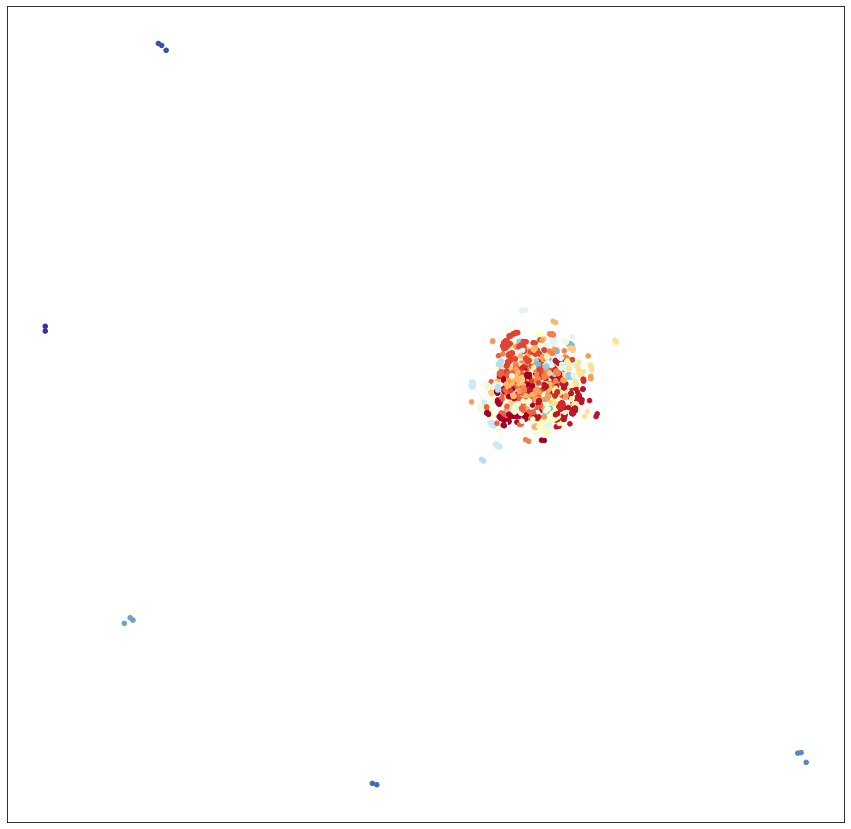

In [33]:
fig = plt.figure(figsize=(15,15))

# Draws a graph and defines color by nodes partitions
nx.draw_networkx_nodes(G, pos, node_size=20, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='lightgray', width=0.1)

plt.show()

Well, there's a bit of curious structure there! Let's see the highest and lowest degree nodes!

In [34]:
top_degree_sequence = sorted([(d, n)for n, d in G.degree()], reverse=True)
bottom_degree_sequence = sorted([(d, n)for n, d in G.degree()], reverse=False)

In [35]:
pd.DataFrame(top_degree_sequence, columns=['Occurences', 'Terms']).head()

,Occurences,Terms
0,466,nao
1,335,gaga
2,325,d
3,320,lady
4,312,taylor


In [36]:
pd.DataFrame(bottom_degree_sequence, columns=['Occurences', 'Terms']).head()

,Occurences,Terms
0,1,ansiosa
1,1,espalhem
2,1,glr
3,1,plmdds
4,1,portugues


For the tweets structure this is it, for now. Let's see how users interact between them.

# 3. Directed Graph Analysis with igraph

Now, we'll consider the mentions between users in order to analyse their relations. Here, we have a directional graph: user A can mention user B, which do not imply that user B has also mentioned user A.

For this, we'll change our graph library to igraph.

In [37]:
# Let's list mentioned users
df['mentions'] = df['mentions'].apply(lambda row: ast.literal_eval(row))
df['mentions'] = df['mentions'].apply(lambda row: [item['screen_name'] for item in row if item != None])
df['mentions'].head()

0                   []
1    [acessokatyperry]
2       [AcervoCharts]
3    [MileyRevoIution]
4           [Roarazes]
Name: mentions, dtype: object

In [38]:
# Let's get every mention and explode it on rows
tst = df[['user_screen_name', 'mentions']].explode('mentions')

print(tst.shape)

(583, 2)


In [39]:
tst = tst.dropna() # Drops if any NaN row

print(tst.shape)

(421, 2)


In [40]:
# Assign the number 1 for every row -- to count and assign weights
tst['count'] = 1

# We group every mention, and use the above column to count how many mentions a user
# has mentioned another
tst = tst.groupby(by=['user_screen_name', 'mentions'], as_index=False).sum().sort_values(by=['count'], ascending=False)

# Then, we rename this column as weight
tst.rename(columns={"count": "weight"}, inplace=True)

In [41]:
# Here, we define a directed Graph with TupleList. Obviously, it expects tuples as input
# Then, we convert the dataframe with the itertuples method. You may check a bit more on 
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.itertuples.html
# Besides that, the TupleList method expects the edges and a weight column
    # which we defined earlier. So, when we define weights=True, it will use
    # this field
g = Graph.TupleList(tst.itertuples(index=False), directed=True, weights=True)

We then plot the graph:

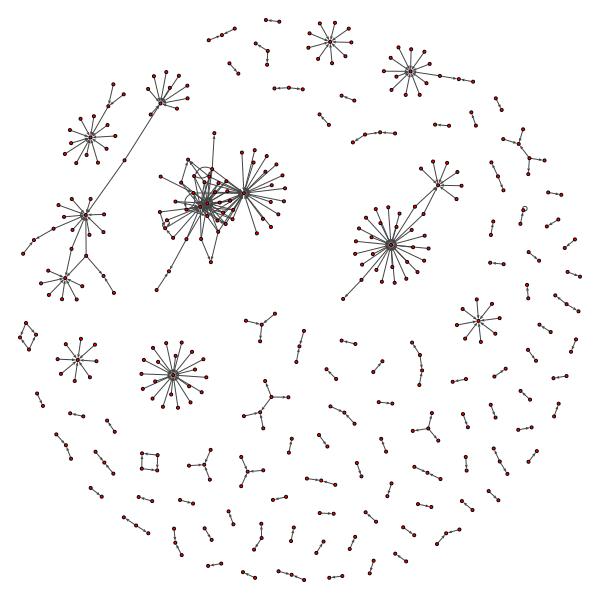

In [42]:
out = plot(g, bbox = (600, 600), vertex_size=3, edge_width=1, edge_arrow_size=0.3)
out.save('nodes_no_communities.png')
out

Interesting! We can see that there's a lot of small groups in here! So finally, we may plot our graph again, this time identifying communities by color, and also plotting the names for profiles that are central in their communities: here, we're plotting labels for profiles that have 8 or more _in degrees!_

In [43]:
# We'll create an empty list called hubs
hubs = []

# This returns a list of degrees for each vertex
in_degrees = g.degree(mode=IN, loops=True)

# For each vertex, it will analyze if it has 8 or more in degrees
# If so, it will add its name as label, if not, it will add an
# empty string
for index, item in enumerate(in_degrees):
    if item >= 8:
        hubs.append(g.vs[index]["name"])
    else:
        hubs.append('')

# Finally, we set the labels. This is because the plot method
# Automatically search for a "label" attribute to plot
g.vs["label"] = hubs

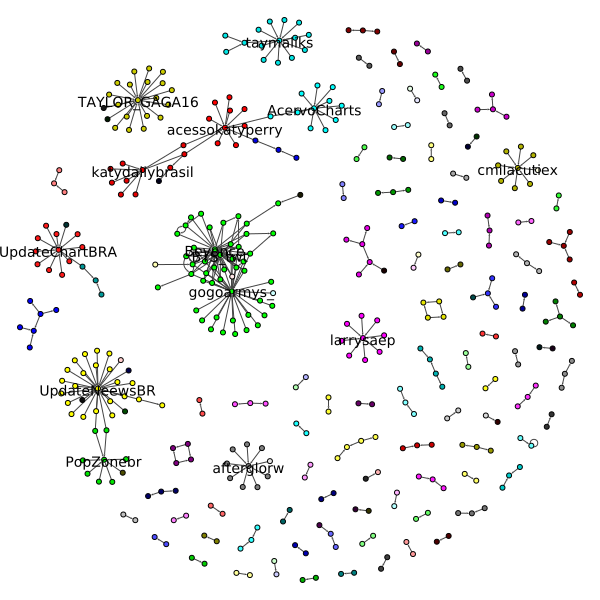

In [44]:
# https://stackoverflow.com/questions/9471906/what-are-the-differences-between-community-detection-algorithms-in-igraph
# https://stackoverflow.com/questions/37855553/python-igraph-community-cluster-colors
i = g.community_infomap(edge_weights=None, vertex_weights=tst['weight'], trials=10)

pal = drawing.colors.ClusterColoringPalette(len(i))
g.vs['color'] = pal.get_many(i.membership)

out_comunnities = plot(g, bbox = (600, 600), vertex_size=5, edge_width=1, edge_arrow_size=0.2)
out_comunnities.save('nodes_communities.png')
out_comunnities

We may see that there's a bit of misclassifying that would need further investigation. I'll let this one for the next version of this notebook. I hope you like it! Hopefully, this is it! A gentle intro to API calls, NLP and Graph Analysis with NetworkX and igraph!

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Happy_smiley_face.png/600px-Happy_smiley_face.png" width=300px height=300px/>